List the approach names below:

In [26]:
MODELS = ['pointnet', 'pointnet++', 'so-net']

For every model there are 4 files generated in numpy binary format:

  **num_votes_accs.npy** - numpy array of size **MODELS COUNT x VOTES COUNT** with classification accuracy for each of 10 individually trained models of one approach (stored in rows) and different number of votes (stored in columns)

  **probabilities.npy** - numpy array of size **MODELS COUNT x TEST POINT CLOUDS CLOUD x CLASSES COUNT** with output classification probability for each of 10 individually trained models

  **true_labels.npy** - numpy array of size **TEST POINT CLOUDS CLOUD** with true labels data

  **accuracies.npy** - numpy array of size **MODELS COUNT** with classification accuracy for each individually trained model of one approach

In [27]:
CLASSES_COUNT = 40
MODELS_COUNT = 10

import os
import numpy as np
probabilities = {}
true_labels = {}
for model in MODELS:
    prob_filepath = os.path.join(model, 'probabilities.npy')
    probabilities[model] = np.load(prob_filepath)
    probabilities[model] = np.transpose(probabilities[model], axes=(2, 0, 1))
    label_filepath = os.path.join(model, 'true_labels.npy')
    true_labels[model] = np.load(label_filepath)

Now, we want to know how instance classification accuracy depends on the number of the ensemble of independently train models. We will check two ensembling methods: mean and mode operation and for each number of ensembled models there will be ten different sets taken into consideration and the median value will be shown on the figures below.

In [41]:
####################################################################################
# Constants
####################################################################################

ENSEMBLE_MODELS_NUMBER = 10

import statistics
from scipy import stats

####################################################################################
# Get random subsets
####################################################################################

def get_random_subsets(models_count, num_ens, num_sets=10):
    """
    Get random num_sets subsets of numbers from 0 to models_count, where each set has num_ens numbers.
    """
    subsets = []   
    while len(subsets) != num_sets:
        candidate = np.sort(np.random.choice(models_count, num_ens, replace=False))
        if not np.array([(el == candidate).all() for el in subsets]).any():
            subsets.append(candidate)
    return np.array(subsets)

subsets = {}
for num_ens in range(1, ENSEMBLE_MODELS_NUMBER):
    subset = get_random_subsets(len(probabilities[model]), num_ens)
    subsets[num_ens] = subset

####################################################################################
# Calc acc
####################################################################################

instance_accuracy = {}
for model in MODELS:
    instance_accuracy[model] = {}
    for num_ens in subsets:
        num_ens_accs = []
        for subset in subsets[num_ens]:
            preds = []
            true = true_labels[model]
            for model_no in subset:
                preds.append(np.argmax(probabilities[model][model_no], axis=-1))
            preds = np.transpose(np.array(preds))
            preds = np.squeeze(stats.mode(preds, axis=-1)[0])
            accy = float(np.sum(preds == true))/len(true)
            num_ens_accs.append(accy)
        instance_accuracy[model][num_ens] = statistics.median(num_ens_accs)

Plot instance accuracy in the function of ensambled individually trained models.

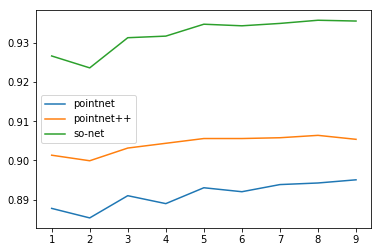

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

handles = []
for model in MODELS:
    x = instance_accuracy[model].keys()
    y = [instance_accuracy[model][i] for i in x]
    handle, = plt.plot(x, y, label=model)
    handles.append(handle)
plt.legend(handles=handles)